# Object Detection - Labeling & Bounding Boxes

This notebook implements ideas and exercises from Lesson 8 of fast.ai's Deep Learning 2 course (2018 Version), documenting an approach to object detection utilizing the fast.ai libraries built on top of PyTorch. 

* **Author**: ksferguson (K. Scott Ferguson)
* **Type**: Deep Learning
* **Stack**: fast.ai over pyTorch
* **Pattern**: Object Detection
* **Problem**: Identify Primary Object Class and Draw Bounding Box
* **Dataset**: PASCAL VOC

First we classify the largest object in the image, then find the four coordinates of a bounding box by regression, then combine the two into a single task. Multiple object detection is pursued in the next notebook.

## fast.ai General Approach

A. Utilize Transfer Learning whenever possible

B. Start simple, then use stepwise refinement

C. Train to Overfitting, then tweak back

1. Add (more) Data
2. Add (more) Data Augmentation
3. Add (more) Batch Normalization
4. Add (more) Regularization (Dropout, Weight Decay)
5. Reduce model complexity

### General Setup

* fast.ai PaperSpace Setup Notes: https://gist.github.com/ksferguson/0b384e892689617d1539d35c1254eb01
* Ubuntu Setup Notes for Dell 7559 with GTX 960M: https://gist.github.com/ksferguson/a6eba79df658826cacb629dcc14992eaPaperSpace


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#superset of imports
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
#torch.cuda.set_device(0)

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

### Data

Download Links

* Mirror: https://pjreddie.com/projects/pascal-voc-dataset-mirror/
* JSON: https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
* Forum: http://forums.fast.ai/t/part-2-lesson-8-wiki/13556  
* Original: http://host.robots.ox.ac.uk/pascal/VOC/


In [5]:
#!curl -OL http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#!curl -OL http://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
#!curl -OL http://pjreddie.com/media/files/VOCdevkit_08-Jun-2007.tar
#!curl -OL http://pjreddie.com/media/files/VOC2007_doc.pdf

#!curl -OL http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
#!curl -OL http://pjreddie.com/media/files/VOC2012test.tar
#!curl -OL http://pjreddie.com/media/files/VOCdevkit_18-May-2011.tar
#!curl -OL http://pjreddie.com/media/files/VOC2012_doc.pdf

In [6]:
PATH = Path ('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/VOCdevkit_08-Jun-2007.tar'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/VOC2012test.tar'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/VOC2012_doc.pdf'),
 PosixPath('data/pascal/VOCtrainval_11-May-2012.tar'),
 PosixPath('data/pascal/VOC2007_doc.pdf'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/VOCtest_06-Nov-2007.tar'),
 PosixPath('data/pascal/VOCdevkit_18-May-2011.tar'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/tmp')]

In [7]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [8]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']

In [9]:
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
 {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
 {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23},
 {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26},
 {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]

In [10]:
trn_j[ANNOTATIONS][:3]

[{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
  'area': 34104,
  'iscrowd': 0,
  'image_id': 12,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0},
 {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
  'area': 13110,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0},
 {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
  'area': 81326,
  'iscrowd': 0,
  'image_id': 17,
  'bbox': [89, 77, 314, 259],
  'category_id': 13,
  'id': 3,
  'ignore': 0}]

In [11]:
trn_j[CATEGORIES][:7]

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'}]

In [12]:
FILENAME, ID, IMG_ID, CAT_ID, BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
cats[3]

'bird'

In [13]:
trn_fns = {o[ID]:o[FILENAME] for o in trn_j[IMAGES]}
trn_fns[12]

'000012.jpg'

In [14]:
trn_ids = [o[ID] for o in trn_j[IMAGES]]
trn_ids[3] 

26

In [15]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')]

In [16]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'
IMG_PATH = PATH / JPEGS
IMG_PATH

PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages')

In [17]:
list(IMG_PATH.iterdir())[:3]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/006948.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005796.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007006.jpg')]

In [18]:
#convert point + height/width offsets to two corners (topleft, bottomright), numpy style
def coords_bb (bb): return np.array ([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

#convert two corners back to point + height/width offsets list, image style
def offset_bb (bb): return list([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])


bb1 = [229, 219, 105, 281]
print(bb1)

bb2 = coords_bb(bb1)
print(bb2)

bb3 = offset_bb(bb2)
print(bb3)

print (coords_bb(bb3))
print (offset_bb(coords_bb(bb3)))

[229, 219, 105, 281]
[219 229 499 333]
[229, 219, 105, 281]
[219 229 499 333]
[229, 219, 105, 281]


In [19]:
trn_anno =  collections.defaultdict(lambda:[])

for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = coords_bb(bb)
        trn_anno[o[IMG_ID]].append((bb, o[CAT_ID]))

len(trn_anno)

2501

In [20]:
print(trn_j[IMAGES][0][ID])

trn_anno[trn_j[IMAGES][0][ID]]

12


[(array([ 96, 155, 269, 350]), 7)]

In [21]:
cats [trn_j[IMAGES][0][ID]]

'dog'

In [22]:
im = open_image(IMG_PATH/trn_j[IMAGES][0][FILENAME])

In [23]:
def show_img (im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [24]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])


In [25]:
bb1

[229, 219, 105, 281]

In [26]:
bb1[:2]

[229, 219]

In [27]:
bb1[-2:]

[105, 281]

In [28]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline (patch, 4)

In [29]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text (*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

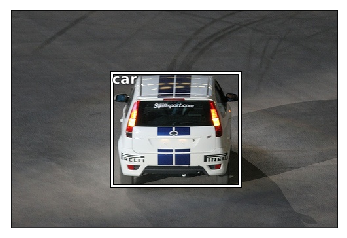

In [30]:
#sample training image
ax = show_img (im)
bb = offset_bb(trn_anno[trn_j[IMAGES][0][ID]][0][0])
draw_rect(ax, bb)
draw_text(ax, bb[:2], cats[trn_anno[trn_j[IMAGES][0][ID]][0][1]])

#trn_anno[trn_j[IMAGES][0][ID]][0][0]
#c = coords_bb(b)


In [31]:
def draw_im(im, anno):
    ax = show_img(im, figsize=(16,8))
    for bb, c in anno:
        bb = offset_bb(bb)
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], cats[c], sz=16)
    

In [32]:
def draw_idx(i):
    im_anno = trn_anno[i]
    im =  open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_anno)

(333, 500, 3)
(364, 480, 3)
(500, 334, 3)
(333, 500, 3)
(281, 500, 3)
(366, 500, 3)
(500, 360, 3)


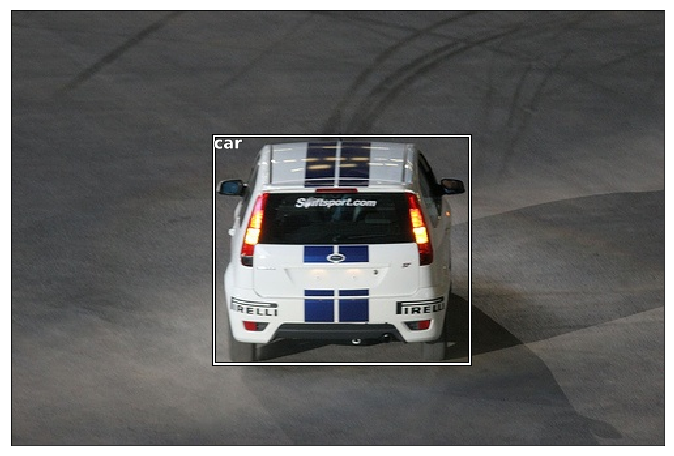

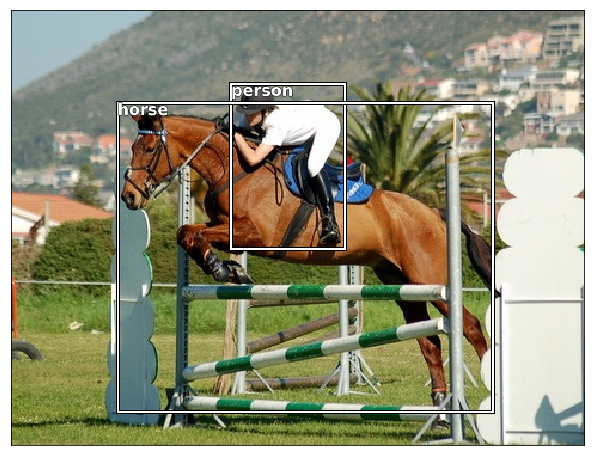

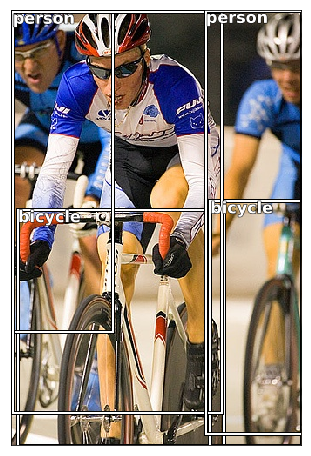

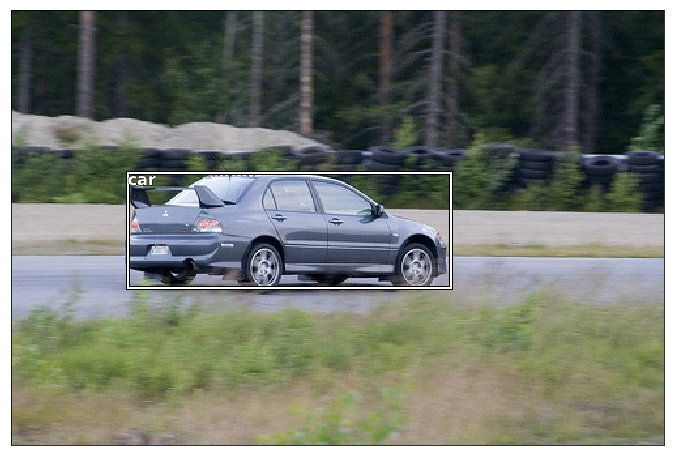

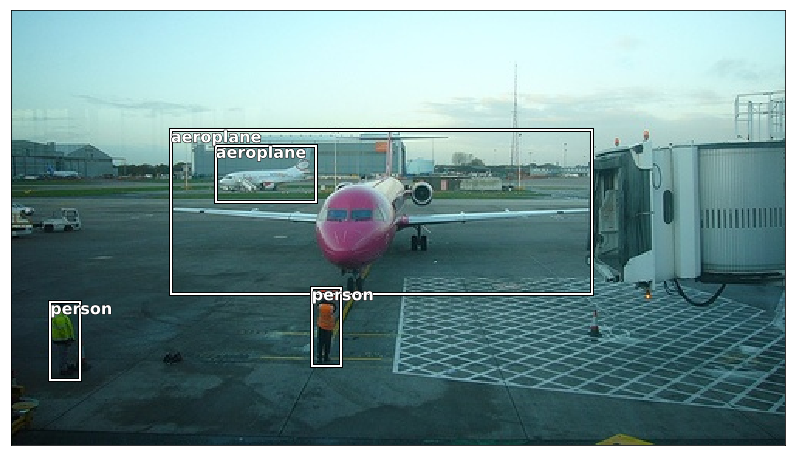

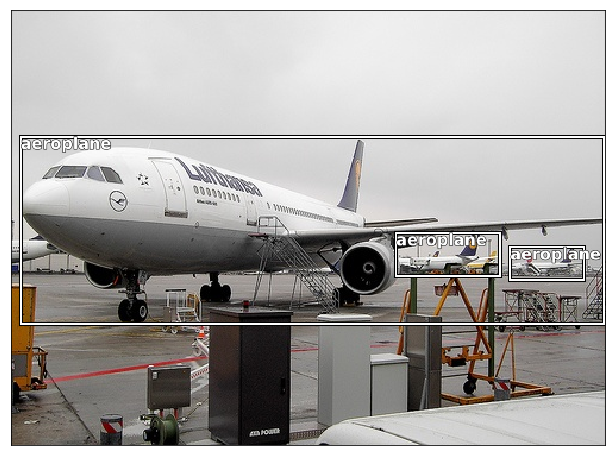

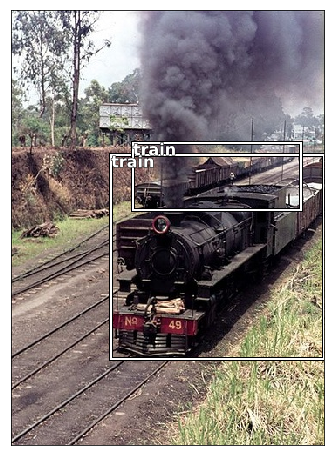

In [33]:
#sample training images with bounding boxes and category labels
for i in list(trn_anno.keys())[:7]: draw_idx(i)
    

## Largest Item Classifier

Step #1: Identify largest item in image and it's category

In [34]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

scratchpad

In [35]:
list(trn_anno.items())[:3]

[(12, [(array([ 96, 155, 269, 350]), 7)]),
 (17, [(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]),
 (23,
  [(array([229,   8, 499, 244]), 2),
   (array([219, 229, 499, 333]), 2),
   (array([  0,   1, 368, 116]), 15),
   (array([  1,   2, 461, 242]), 15),
   (array([  0, 224, 485, 333]), 15)])]

In [36]:
for a, b in list(trn_anno.items())[:3]:
    print (a, b)

12 [(array([ 96, 155, 269, 350]), 7)]
17 [(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]
23 [(array([229,   8, 499, 244]), 2), (array([219, 229, 499, 333]), 2), (array([  0,   1, 368, 116]), 15), (array([  1,   2, 461, 242]), 15), (array([  0, 224, 485, 333]), 15)]


In [37]:
for a in list(trn_anno.keys())[:3]:
    print (a)

12
17
23


In [38]:
bb3 = sorted (trn_anno[23], key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
bb3

[(array([  1,   2, 461, 242]), 15),
 (array([229,   8, 499, 244]), 2),
 (array([  0, 224, 485, 333]), 15),
 (array([  0,   1, 368, 116]), 15),
 (array([219, 229, 499, 333]), 2)]

In [39]:
trn_anno[23]

[(array([229,   8, 499, 244]), 2),
 (array([219, 229, 499, 333]), 2),
 (array([  0,   1, 368, 116]), 15),
 (array([  1,   2, 461, 242]), 15),
 (array([  0, 224, 485, 333]), 15)]

In [40]:
trn_anno[23][0]

(array([229,   8, 499, 244]), 2)

In [41]:
trn_anno[23][-2:]

[(array([  1,   2, 461, 242]), 15), (array([  0, 224, 485, 333]), 15)]

In [42]:
bb3[0]

(array([  1,   2, 461, 242]), 15)

In [43]:
trn_anno[23][:2]

[(array([229,   8, 499, 244]), 2), (array([219, 229, 499, 333]), 2)]

In [44]:
np.product(trn_anno[23][0][0][-2:]-trn_anno[23][0][0][:2])

63720

In [45]:
trn_anno[23][0][0][-2:]

array([499, 244])

In [46]:
trn_anno[23][0][0][:2]

array([229,   8])

In [47]:
trn_anno[23][0][0][-2:]-trn_anno[23][0][0][:2]

array([270, 236])

In [48]:
270 * 236

63720

continuing

In [49]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

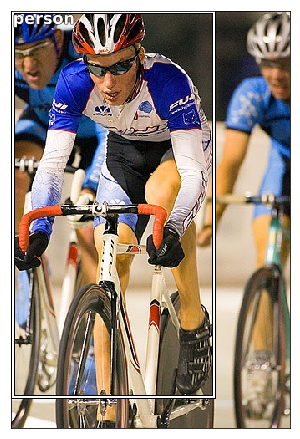

In [50]:
bb, c = trn_lrg_anno[23]
bb = offset_bb(bb)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, bb)
draw_text(ax, bb[:2], cats[c], sz=16)

### Dataset

Build CSV rather than custom dataset.

In [51]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [52]:
CSV

PosixPath('data/pascal/tmp/lrg.csv')

In [53]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
                  'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                 columns=['fn', 'cat'])
df.to_csv(CSV, index=False)

In [54]:
#model
arch =  resnet34
sz = 224
bs = 64

In [55]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [56]:
x, y = next(iter(md.val_dl))

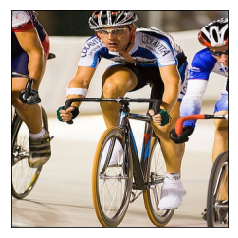

In [57]:
show_img(md.val_ds.denorm(to_np(x))[0])

In [58]:
learn = ConvLearner.pretrained(arch, md, metrics=[accuracy])

In [59]:
learn.opt_fn = optim.Adam

In [60]:
lrf = learn.lr_find(1e-5,100)

 78%|███████▊  | 25/32 [00:05<00:01,  4.31it/s, loss=12.2]


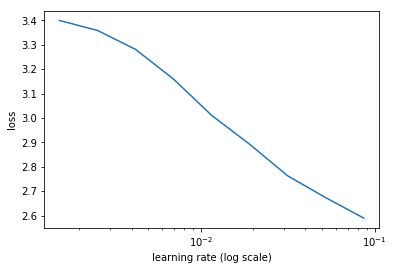

In [61]:
learn.sched.plot()

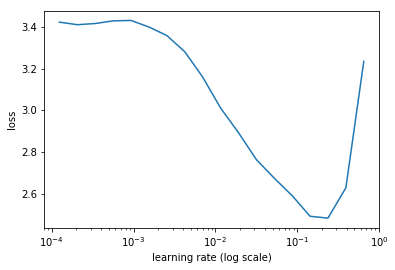

In [62]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [63]:
lr = 2e-2

In [64]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.241537   0.661421   0.812     



[array([0.66142]), 0.8119999995231628]

In [65]:
lrs = np.array([lr/1000, lr/100, lr])

In [66]:
learn.freeze_to(-2)

In [67]:
lrf=learn.lr_find(lrs/1000)

 84%|████████▍ | 27/32 [00:08<00:01,  3.35it/s, loss=4.17] 


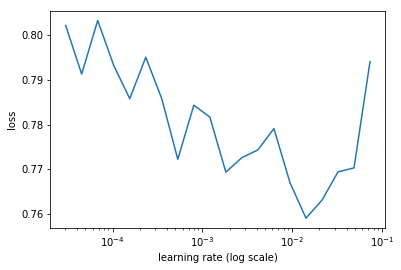

In [68]:
learn.sched.plot(1)

In [69]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.819053   0.616865   0.822     



[array([0.61686]), 0.8220000023841858]

In [70]:
learn.unfreeze()

In [71]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.664323   0.584924   0.832     
    1      0.452472   0.57066    0.83                      



[array([0.57066]), 0.8299999976158142]

In [72]:
learn.save('Class1')

In [73]:
# learn.load('Class1')

In [74]:
# predict
x, y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


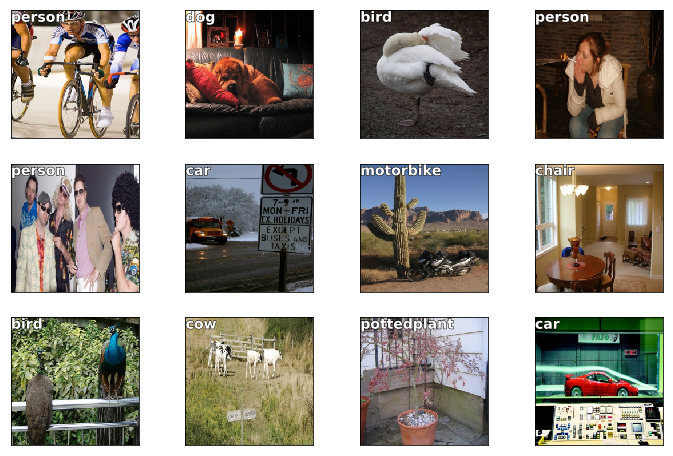

In [75]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
    plt.tight_layout

### Bounding Box for Largest Object

Use regression with four (continuous) outputs to get the bounding box coordinates.

In [76]:
BB_CSV = PATH/'tmp/bb.csv'

In [77]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df =pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [78]:
BB_CSV.open().readlines()[:6]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n',
 '000032.jpg,77 103 182 374\n']

In [79]:
arch = resnet34
sz = 224
bs = 64

In [80]:
#adding tfm_y=TfmType.COORD to have bounding box inputs follow the augmentation changes
augs = [RandomFlip(tfm_y=TfmType.COORD), 
        RandomRotate(30, tfm_y=TfmType.COORD), 
        RandomLighting(0.1, 0.1, tfm_y=TfmType.COORD)]

In [81]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [82]:
md =  ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

In [83]:
#final resnet34 layer output nodes
512 * 7 * 7

25088

In [84]:
#new custom head to regress to 4 box coordinates
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(arch, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [85]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

In [86]:
learn.lr_find(1e-5,100)

 75%|███████▌  | 24/32 [00:05<00:01,  4.38it/s, loss=393] 


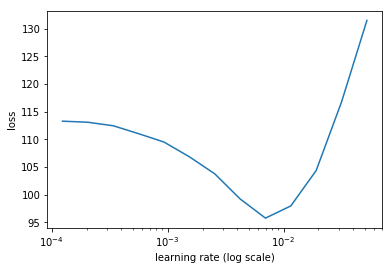

In [87]:
learn.sched.plot(5)

In [88]:
lr = 2e-3

In [89]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      48.417853  33.726945 
    1      36.862515  29.068399                           
    2      31.437872  28.346903                           



[array([28.3469])]

In [90]:
lrs = np.array([lr/100,lr/10,lr])

In [91]:
learn.freeze_to(-2)

In [92]:
lrf=learn.lr_find(lrs/1000)

epoch      trn_loss   val_loss                            
    0      72.893512  4310939892826767.5



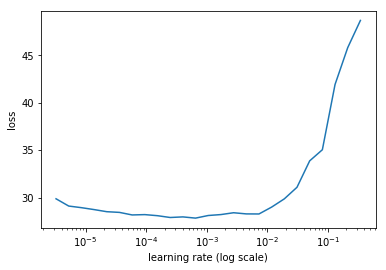

In [93]:
learn.sched.plot(1)

In [94]:
learn.fit(lrs/5, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      25.789287  25.483068 
    1      24.264122  23.890858                           
    2      22.871652  23.530507                           



[array([23.53051])]

In [95]:
learn.freeze_to(-3)

In [96]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss                            
    0      21.509067  22.564774 
    1      20.388976  22.226406                           



[array([22.22641])]

In [97]:
learn.save('reg4')

In [98]:
# learn.load('reg4')

In [99]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


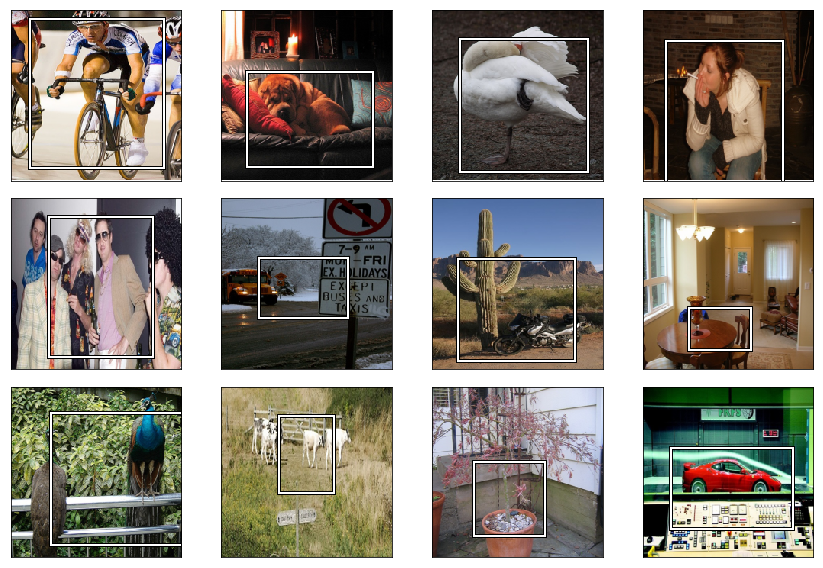

In [100]:
fig, axes = plt.subplots(3,4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b=offset_bb(preds[i])
    ax=show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single Object Detection (Label & Bounding Box)

### Combine datasets

In [101]:
f_model = resnet34
sz = 224
bs = 64

val_idxs = get_cv_idxs (len(trn_fns))

In [102]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)

In [103]:
md =  ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True, val_idxs=val_idxs)

In [104]:
#get classifier labels like before so we can extract dataset
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [105]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [106]:
trn_ds2 = ConcatLblDataset (md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset (md.val_ds, md2.val_y)

In [107]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [108]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [109]:
x,y = next(iter(md.val_dl))
#print(x,y)
idx = 3
imga = md.val_ds.ds.denorm(to_np(x))[idx]
b = offset_bb(to_np(y[0][idx])); b

[52.0, 38.0, 107.0, 185.0]

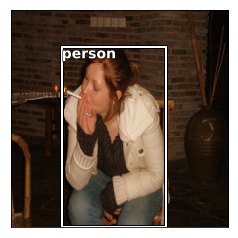

In [110]:
ax = show_img(imga)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

### Build Model & Loss Functions

Outputs:
4 Continous variables (bounding box) + Number of categories (for label)

In [111]:
#custom final layers to replace resnet34's final layer(s)
head_reg4 = nn.Sequential (
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256, 4+len(cats)),
)

models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner (md, models)
learn.opt_fn = optim.Adam

In [112]:
def odet_loss(yhat, y):
    bb1, cat1 = yhat[:,:4],yhat[:,4:]
    bb, cat = y
    return F.l1_loss(bb1, bb) + F.cross_entropy(cat1, cat) * 20

def odet_l1 (yhat, y):
    bb1 = yhat[:, :4]
    bb,_ = y
    #ksf - unclear what this 'squeeze to center' was meant to accomplish
    #bb1 = F.sigmoid(bb1)*224
    return F.l1_loss(V(bb1), V(bb)).data

def odet_acc (yhat, y):
    cat1 = yhat[:,4:]
    _,cat = y
    return accuracy (cat1, cat)

learn.crit = odet_loss
learn.metrics = [odet_acc, odet_l1]
    

### Train Model

In [113]:
learn.lr_find()

 97%|█████████▋| 31/32 [00:06<00:00,  4.79it/s, loss=820]


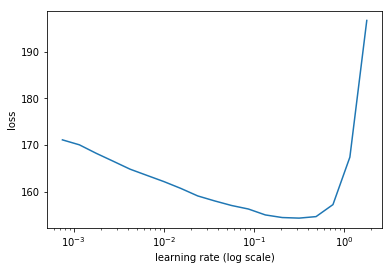

In [114]:
learn.sched.plot(n_skip_end=1)

In [115]:
lr = 1e-2

In [116]:
learn.save('objdet1')

In [117]:
#learn.load('objdet1')

In [118]:
#need to dig through the learner.py code on clr (presumably a cyclic learning rate)
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

epoch      trn_loss   val_loss   odet_acc   odet_l1      
    0      142.513279 126.408432 0.82       114.167297
    1      129.933168 113.19015  0.822      102.488464   
    2      118.716862 103.625836 0.826      93.397104    



[array([103.62584]), 0.8260000023841858, 93.397103515625]

In [119]:
learn.freeze_to(-2)

In [120]:
lrs = np.array([lr/100, lr/10, lr])

In [121]:
learn.lr_find(lrs/1000)

 94%|█████████▍| 30/32 [00:09<00:00,  3.06it/s, loss=613]


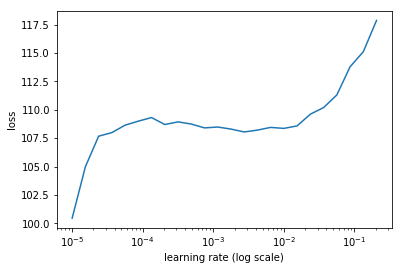

In [122]:
learn.sched.plot(0)

In [123]:
learn.fit(lrs/5, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   odet_acc   odet_l1      
    0      106.5426   105.525783 0.794      90.089105 
    1      100.91138  98.225967  0.784      84.231896    
    2      93.865997  87.859704  0.776      74.302342     
    3      86.70477   82.615555  0.81       70.08467      
    4      79.892302  75.842847  0.81       62.395272     
    5      73.492304  70.83673   0.802      58.528343     
    6      67.846755  66.248231  0.818      53.633047     
    7      62.818284  63.105429  0.822      50.872458     
    8      59.191733  61.441936  0.834      49.15526      
    9      56.328498  60.018645  0.84       47.811005     



[array([60.01864]), 0.8399999980926514, 47.81100518798828]

In [124]:
learn.save('objdet1a')

In [125]:
learn.unfreeze()

In [126]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

epoch      trn_loss   val_loss   odet_acc   odet_l1       
    0      51.505307  57.104612  0.82       44.993327 
    1      49.25395   54.681554  0.8        40.020465     
    2      45.915459  52.192811  0.81       37.988574     
    3      42.886807  47.792894  0.806      33.66295      
    4      39.285102  46.163074  0.796      31.52948      
    5      35.962037  43.10119   0.808      29.612694     
    6      33.415584  40.833244  0.826      28.212947     
    7      31.406558  40.843383  0.822      27.889715     
    8      29.799512  40.494323  0.822      27.385302     
    9      28.656202  39.666562  0.832      27.20443      



[array([39.66656]), 0.8320000028610229, 27.20442953491211]

In [127]:
yhat = learn.predict()
x,_ = next(iter(md.val_dl))

In [128]:
#from scipy.special import expit

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


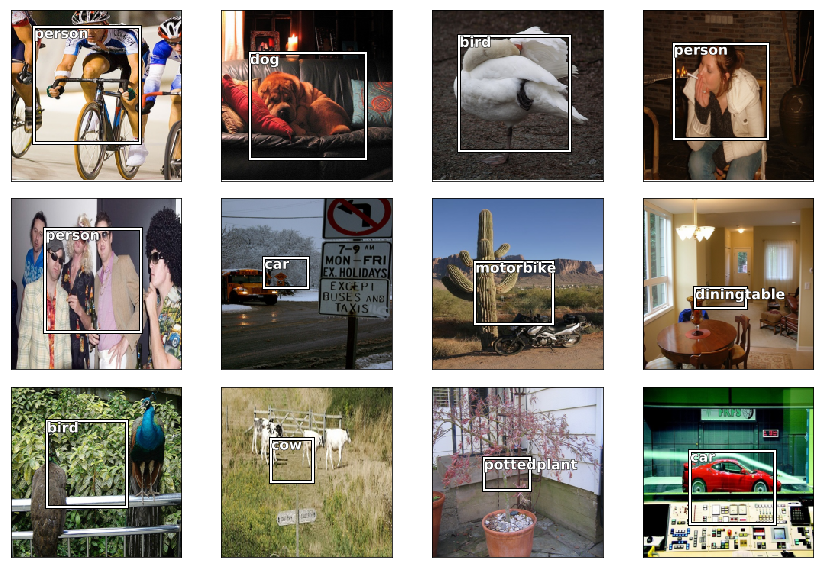

In [129]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate (axes.flat):
    img_a = md.val_ds.ds.denorm(to_np(x))[i]
    bb1 = yhat[i][:4]
    #ksf - unclear what Jeremy was doing with the expit function (similar to sigmoid in l1 loss function?)
    #bb1 = expit(yhat[i][:4])*224
    bb1 = offset_bb(bb1)
    cat1 = np.argmax(yhat[i][4:])
    ax = show_img(img_a, ax=ax)
    draw_rect(ax, bb1)
    draw_text(ax, bb1[:2], md2.classes[cat1])
plt.tight_layout()

## Results Analysis

We see some success (~83%) in identifying a major object and constructing a bounding box in the general area of interest, albeit with overfitting starting to come into play. Problems are evident when multiple objects are found in image. This work continues with multipe object detection in the next notebook.